# Universal Sentence Embeddings

- This is based on Ch 10 of Text Analytics with Python by Dipanjan Sarkar
- [source](https://www.curiousily.com/posts/sentiment-analysis-with-tensorflow-2-and-keras-using-python/)
- [source](https://www.dlology.com/blog/keras-meets-universal-sentence-encoder-transfer-learning-for-text-data/)

## Loading Libaries

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

In [2]:
## Check GPU if any
# tf.test.is_gpu_available()
tf.test.gpu_device_name()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data

- The original [IMDB Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/)
    - The original data include each text as an independent text file
- [Sarkar's repository](https://github.com/dipanjanS/data_science_for_all/tree/master/tds_deep_transfer_learning_nlp_classification) for csv file

In [114]:
# import tarfile
# tar = tarfile.open("../data/movie_review.tar.gz")
# tar.extractall(path="../data/stanford-movie-review/")
# tar.close()

In [115]:
# import os
# import tarfile

# def csv_files(members):
#     for tarinfo in members:
#         if os.path.splitext(tarinfo.name)[1] == ".csv":
#             yield tarinfo

# tar = tarfile.open("../data/movie_review.tar.gz")
# tar.extractall(path='../data/', members=csv_files(tar))
# tar.close()

In [116]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [117]:
dataset = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/movie_reviews.csv.bz2',
                     compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [118]:
dataset.dtypes

review       object
sentiment    object
dtype: object

In [119]:
## Recode sentiment

dataset['sentiment'] = [1 if sentiment=='positive' else 0 for sentiment in dataset['sentiment'].values]
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [120]:
dataset.dtypes

review       object
sentiment     int64
dtype: object

## Train, Validation, and Test Sets Splitting

In [10]:
## Method 1 sklearn
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(reviews, test_size = 0.33, random_state=42)

## Method 2 numpy
train, validate, test = np.split(dataset.sample(frac=1), [int(.6*len(dataset)), int(.7*len(dataset))])

In [11]:
train.shape, validate.shape, test.shape
train.head()

,review,sentiment
30463,A have a female friend who is currently being ...,1
3960,"If there's one theme of this film, it's that p...",1
36812,Ninja Hunter (AKA Wu Tang vs Ninja) is pure en...,1
47930,I can say without a shadow of a doubt that Goi...,0
11350,Just once I'd like to see a version of Beowulf...,0


## Text Wranlging

- Text preprocessing usually takes care of:
    - unnecessary html tags
    - non-ASCII characters in English texts (e.g., accented characters)
    - contraction issues
    - special characters (unicode)

In [12]:
## libaries for text pre-processing
!pip3 install contractions
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re


In [13]:
## Functions for Text Preprocessing

def strip_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    [s.extract() for s in soup(['iframe','script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore'). decode('utf-8', 'ignore')
    return text
def expand_contractions(text): 
    return contractions.fix(text)
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]' 
    text = re.sub(pattern, '', text)
    return text
def pre_process_document(document):
    # strip HTML
    document = strip_html_tags(document)
    # case normalization
    document = document.lower()
    # remove empty lines
    document = document.translate(document.maketrans("\n\t\r", "   "))
    # remove accented characters
    document = remove_accented_chars(document)
    # expand contractions
    document = expand_contractions(document)
    # remove special characters and\or digits
    # insert spaces between special characters to isolate them 
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)
    # remove extra whitespace
    document = re.sub(' +', ' ', document) 
    document = document.strip()
    return document

# vectorize function
pre_process_corpus = np.vectorize(pre_process_document)

In [14]:
pre_process_corpus(train['review'].values[0])

array('a have a female friend who is currently being drawn into a relationship with an sob who has a long term girlfriend of course the sob is very goodlooking charming etc and my friend is a very intelligent woman watching jean pierre leauds character at work is exactly like watching what goes on in real life when guys like that destroy the lives of our female friends it is tragic and you know she is going to end up very hurt but there is nothing you can do leaud is brilliant totally empty a blank throughout he pulls the faces and tells the stories he thinks will get the reaction he wants the scene two hours in when leaud and lebrun have made love and the next morning he puts on a record and very sweetly and charmingly sings along to amuse her is brilliant the what the hell am i doing here with this idiot expression that flickers back and forth across her face will be in my memory for a long time to come it is a long film but see it in one go preferably in a cinema takes a while to ge

In [15]:
%%time
train_reviews = pre_process_corpus(train['review'].values)
train_sentiments = train['sentiment'].values
val_reviews = pre_process_corpus(validate['review'].values)
val_sentiments = validate['sentiment'].values
test_reviews = pre_process_corpus(test['review'].values)
test_sentiments = test['sentiment'].values

CPU times: user 25.6 s, sys: 1.1 s, total: 26.7 s
Wall time: 26.7 s


In [27]:
# train_text = train_reviews.tolist()
train_text = np.array(train_reviews, dtype=object)[:, np.newaxis]
test_text = np.array(test_reviews, dtype=object)[:, np.newaxis]
val_text = np.array(val_reviews, dtype=object)[:, np.newaxis]

train_label = np.asarray(pd.get_dummies(train_sentiments), dtype = np.int8)
test_label = np.asarray(pd.get_dummies(test_sentiments), dtype = np.int8)
val_label = np.asarray(pd.get_dummies(val_sentiments), dtype = np.int8)

In [28]:
print(train_text[1])
print(train_label[1]) # y is one-hot encoding

['if there is one theme of this film it is that people can cope with hardship by having a good imagination this family is poor their father works graveyard and their mother works doubleshifts and peter is constantly picked on for a variety of reasons and becomes increasingly frustrated that he is often mistaken for a girl he is just starting to approach that age of or where your perceptions start to change and thinks like your appearance start to matter the backdrop of this story is the worlds fair and the centennial of canada the films greatest moments come during the various fantasy sequences where we see just how they cope watch the flim and if you have ever had a childhood friend that you dreamt with and then for some reason lost you will really like this film perhaps kids will like this film but only adults will truly appreciate it including its references to bolsheviks and what parents will do for their children']
[0 1]


In [20]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])



In [ ]:
print(len(embeddings[0]))
print(embed(train_text[1])) # train_text[0] sentence embeddings

In [25]:
from tqdm import tqdm

## Converting train_text into embedding
X_train = []
for r in tqdm(train_text):
  emb = embed(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)
X_train = np.array(X_train)

100%|██████████| 30000/30000 [03:24<00:00, 146.63it/s]


In [29]:
## Converting test_text into embeddings
X_test = []
for r in tqdm(test_text):
  emb = embed(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)
X_test = np.array(X_test)

100%|██████████| 15000/15000 [01:43<00:00, 145.51it/s]


In [31]:
## Converting val_text into embeddings
X_val = []
for r in tqdm(val_text):
  emb = embed(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_val.append(review_emb)
X_val = np.array(X_val)

100%|██████████| 5000/5000 [00:34<00:00, 146.26it/s]


In [33]:
import keras
model = keras.Sequential()
model.add(
  keras.layers.Dense(
    units=256,
    input_shape=(X_train.shape[1], ),
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)
model.add(
  keras.layers.Dense(
    units=128,
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)
model.add(keras.layers.Dense(2, activation='softmax'))
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [146]:
history = model.fit(
    X_train, train_label,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    verbose=1,
    shuffle=True
)

Epoch 1/50
211/211 [==============================] - 1s 3ms/step - loss: 0.0907 - accuracy: 0.9649 - val_loss: 0.4847 - val_accuracy: 0.8663
Epoch 2/50
211/211 [==============================] - 1s 3ms/step - loss: 0.0943 - accuracy: 0.9635 - val_loss: 0.4747 - val_accuracy: 0.8693
Epoch 3/50
211/211 [==============================] - 1s 3ms/step - loss: 0.0887 - accuracy: 0.9663 - val_loss: 0.4798 - val_accuracy: 0.8653
Epoch 4/50
211/211 [==============================] - 1s 3ms/step - loss: 0.0826 - accuracy: 0.9689 - val_loss: 0.4820 - val_accuracy: 0.8640
Epoch 5/50
211/211 [==============================] - 1s 3ms/step - loss: 0.0828 - accuracy: 0.9681 - val_loss: 0.4939 - val_accuracy: 0.8663
Epoch 6/50
211/211 [==============================] - 1s 3ms/step - loss: 0.0780 - accuracy: 0.9704 - val_loss: 0.4925 - val_accuracy: 0.8637
Epoch 7/50
211/211 [==============================] - 1s 3ms/step - loss: 0.0765 - accuracy: 0.9714 - val_loss: 0.5111 - val_accuracy: 0.8687
Epoch 

In [147]:
## plotting 

import pandas as pd

history.history

history_df = pd.DataFrame(list(zip(history.history['loss'],history.history['accuracy'], history.history['val_loss'], history.history['val_accuracy'])),
                          columns=['loss','accuracy','val_loss','val_accurary'])
history_df['epoch']=list(range(1,len(history_df['loss'])+1,1))

In [52]:
history_df

,loss,accuracy,val_loss,val_accurary,epoch
0,0.419730,0.809000,0.322251,0.862000,1
1,0.330260,0.858259,0.312898,0.864000,2
2,0.320665,0.863407,0.308870,0.864333,3
3,0.310101,0.867481,0.303316,0.867333,4
4,0.304804,0.871926,0.302841,0.873000,5
5,0.292450,0.876519,0.296977,0.873667,6
6,0.283341,0.884704,0.297412,0.869000,7
7,0.275332,0.884630,0.299703,0.868667,8
8,0.265320,0.893037,0.299673,0.872000,9
9,0.255613,0.896852,0.300012,0.873333,10


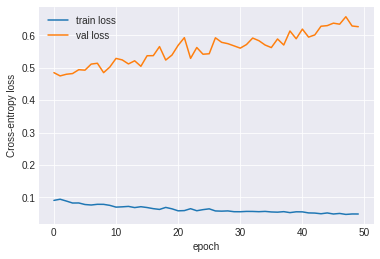

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();


# # style
# plt.style.use('seaborn-darkgrid')
 
# # create a color palette
# palette = plt.get_cmap('Set1')
 
# # multiple line plot
# num=0
# for column in history_df.drop(['epoch','loss','val_loss'], axis=1):
#   num+=1
#   plt.plot(history_df['epoch'], history_df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
 
# # Add legend
# plt.legend(loc=2, ncol=2)
 
# # Add titles
# plt.title("A (bad) Spaghetti plot", loc='left', fontsize=12, fontweight=0, color='orange')
# plt.xlabel("Time")
# plt.ylabel("Score")


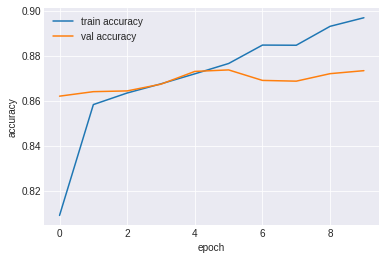

In [71]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [149]:
model.evaluate(X_test, test_label)

469/469 [==============================] - 1s 2ms/step - loss: 0.6929 - accuracy: 0.8607


[0.6929293870925903, 0.8606666922569275]

In [136]:
y_pred = model.predict(X_test) 
#y_pred = np.argmax(y_pred, axis = 1)[:5] 
label = np.argmax(test_label,axis = 1)[:5] 
print(y_pred[:5])
print(label[:5])

[[1.4283112e-01 8.5716891e-01]
 [5.6122297e-01 4.3877703e-01]
 [1.6821243e-01 8.3178753e-01]
 [1.0710892e-07 9.9999988e-01]
 [6.6318661e-01 3.3681333e-01]]
[1 1 0 1 0]


In [128]:
y_pred = model.predict(X_test[:1])
print(y_pred)

"Bad" if np.argmax(y_pred) == 0 else "Good"

[[0.1428309 0.8571691]]


'Good'

In [131]:

print(test_text[1])

['i love the series many of the stereotypes portraying southerrners as hicks are very apparent but such people do exist all too frequently the portrayal of southern government rings all too true as well but the sympathetic characters reminds one of the many good things about the south as well some things never change and we see the good old boys every day there is a lucas buck in every southern town who has only to make a phone call to make things happen and the storybook po white trash are all too familiar aside from the supernatural elements everything else could very well happen in the modern south i somehow think trinity sc must have been in barnwell county']


In [150]:
# functions from Text Analytics with Python book
def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))

def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  codes=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                codes=level_labels)) 
    print(cm_frame) 
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)
from sklearn import metrics

In [151]:
test_pred = model.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
print(test_pred)
print(test_sentiments)
display_model_performance_metrics(test_sentiments, test_pred)

[1 1 1 ... 1 0 1]
[1 1 0 ... 1 0 1]
Model Performance metrics:
------------------------------
Accuracy: 0.8607
Precision: 0.8607
Recall: 0.8607
F1 Score: 0.8607

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.86      0.87      0.86      7538
           0       0.86      0.85      0.86      7462

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       6539   999
        0       1091  6371
